# Classification Methods: Predicting Hotel Cancellations

### Python version

In [1]:
from platform import python_version
print(python_version())

### Import Libraries

In [2]:
import csv
import imblearn
import matplotlib.pyplot as plt
import mglearn
import numpy as np
from numpy.random import seed
seed(1)

import os
import pandas as pd
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

### Import Data From AWS S3 to Sagemaker

In [ ]:
# import boto3
# import botocore
# from sagemaker import get_execution_role

# role = get_execution_role()

# bucket = 'enterbucketname'
# data_key_train = 'H1.csv'
# data_location_train = 's3://{}/{}'.format(bucket, data_key_train)

# train_df = pd.read_csv(data_location_train)

### Import Data From Azure Blob Storage to Azure Machine Learning Studio

In [ ]:
# from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient

# #download csv file from Azure blob

# sas_url = "enter url here"
# blob_client = BlobClient.from_blob_url(sas_url)
# downloaded_blo = blob_client.download_blob()

In [ ]:
# from io import StringIO
# blob_data = blob_client.download_blob()
# train_df = pd.read_csv(StringIO(blob_data.content_as_text()))
# print(train_df)

### Import Data Through CSV

In [3]:
train_df = pd.read_csv('H1.csv')
a=train_df.head()
b=train_df
b
b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)

IsCanceled  LeadTime  ArrivalDateYear ArrivalDateMonth  \
0               0       342             2015             July   
1               0       737             2015             July   
2               0         7             2015             July   
3               0        13             2015             July   
4               0        14             2015             July   
...           ...       ...              ...              ...   
40055           0       212             2017           August   
40056           0       169             2017           August   
40057           0       204             2017           August   
40058           0       211             2017           August   
40059           0       161             2017           August   

       ArrivalDateWeekNumber  ArrivalDateDayOfMonth  StaysInWeekendNights  \
0                         27                      1                     0   
1                         27                      1                     0   
2                         27                      1                     0   
3                         27                      1                     0   
4                         27                      1                     0   
...                      ...                    ...                   ...   
40055                     35                     31                     2   
40056                     35                     30                     2   
40057                     35                     29                     4   
40058                     35                     31                     4   
40059                     35                     31                     4   

       StaysInWeekNights  Adults  Children  ...      DepositType        Agent  \
0                      0       2         0  ...  No Deposit              NULL   
1                      0       2         0  ...  No Deposit              NULL   
2                      1       1         0  ...  No Deposit              NULL   
3                      1       1         0  ...  No Deposit               304   
4                      2       2         0  ...  No Deposit               240   
...                  ...     ...       ...  ...              ...          ...   
40055                  8       2         1  ...  No Deposit               143   
40056                  9       2         0  ...  No Deposit               250   
40057                 10       2         0  ...  No Deposit               250   
40058                 10       2         0  ...  No Deposit                40   
40059                 10       2         0  ...  No Deposit                69   

           Company DaysInWaitingList     CustomerType     ADR  \
0             NULL                 0        Transient    0.00   
1             NULL                 0        Transient    0.00   
2             NULL                 0        Transient   75.00   
3             NULL                 0        Transient   75.00   
4             NULL                 0        Transient   98.00   
...            ...               ...              ...     ...   
40055         NULL                 0        Transient   89.75   
40056         NULL                 0  Transient-Party  202.27   
40057         NULL                 0        Transient  153.57   
40058         NULL                 0         Contract  112.80   
40059         NULL                 0        Transient   99.06   

       RequiredCarParkingSpaces  TotalOfSpecialRequests ReservationStatus  \
0                             0                       0         Check-Out   
1                             0                       0         Check-Out   
2                             0                       0         Check-Out   
3                             0                       0         Check-Out   
4                             0                       1         Check-Out   
...                         ...                     ...               ...   
40055   

In [4]:
IsCanceled = train_df['IsCanceled']
y = IsCanceled

### Numerical Variables

In [5]:
leadtime = train_df['LeadTime']
arrivaldateyear = train_df['ArrivalDateYear']
arrivaldateweekno = train_df['ArrivalDateWeekNumber']
arrivaldatedayofmonth = train_df['ArrivalDateDayOfMonth']
staysweekendnights = train_df['StaysInWeekendNights']
staysweeknights = train_df['StaysInWeekNights']
adults = train_df['Adults']
children = train_df['Children']
babies = train_df['Babies']
previouscancellations = train_df['PreviousCancellations']
previousbookingsnotcanceled = train_df['PreviousBookingsNotCanceled']
bookingchanges = train_df['BookingChanges']
dayswaitinglist = train_df['DaysInWaitingList']
adr = train_df['ADR']
rcps = train_df['RequiredCarParkingSpaces']
totalsqr = train_df['TotalOfSpecialRequests']

### Categorical Variables

In [6]:
arrivaldatemonth = train_df.ArrivalDateMonth.astype("category").cat.codes
arrivaldatemonthcat=pd.Series(arrivaldatemonth)
mealcat=train_df.Meal.astype("category").cat.codes
mealcat=pd.Series(mealcat)
countrycat=train_df.Country.astype("category").cat.codes
countrycat=pd.Series(countrycat)
marketsegmentcat=train_df.MarketSegment.astype("category").cat.codes
marketsegmentcat=pd.Series(marketsegmentcat)
distributionchannelcat=train_df.DistributionChannel.astype("category").cat.codes
distributionchannelcat=pd.Series(distributionchannelcat)
reservedroomtypecat=train_df.ReservedRoomType.astype("category").cat.codes
reservedroomtypecat=pd.Series(reservedroomtypecat)
assignedroomtypecat=train_df.AssignedRoomType.astype("category").cat.codes
assignedroomtypecat=pd.Series(assignedroomtypecat)
deposittypecat=train_df.DepositType.astype("category").cat.codes
deposittypecat=pd.Series(deposittypecat)
customertypecat=train_df.CustomerType.astype("category").cat.codes
customertypecat=pd.Series(customertypecat)
reservationstatuscat=train_df.ReservationStatus.astype("category").cat.codes
reservationstatuscat=pd.Series(reservationstatuscat)
isrepeatedguestcat = train_df.IsRepeatedGuest.astype("category").cat.codes
isrepeatedguestcat=pd.Series(isrepeatedguestcat)
agentcat = train_df.Agent.astype("category").cat.codes
agentcat=pd.Series(agentcat)
companycat = train_df.Company.astype("category").cat.codes
companycat=pd.Series(companycat)

In [7]:
x = np.column_stack((leadtime,arrivaldateyear,arrivaldatemonthcat,arrivaldateweekno,arrivaldatedayofmonth,staysweekendnights,staysweeknights,adults,children,babies,mealcat,countrycat,marketsegmentcat,distributionchannelcat,isrepeatedguestcat,previouscancellations,previousbookingsnotcanceled,reservedroomtypecat,assignedroomtypecat,bookingchanges,deposittypecat,dayswaitinglist,customertypecat,adr,rcps,totalsqr,reservationstatuscat))
x = sm.add_constant(x, prepend=True)

## Feature Selection

### Wrapper-Based: Forward Search

In [8]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector

forward_feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
           k_features=6,
           forward=True,
           verbose=2,
           scoring='roc_auc',
           cv=4)

In [9]:
fselector = forward_feature_selector.fit(x, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   38.2s finished

[2020-11-07 13:26:13] Features: 1/6 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   33.4s finished

[2020-11-07 13:26:46] Features: 2/6 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   35.8s finished

[2020-11-07 13:27:22] Features: 3/6 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0

In [10]:
fselector.k_feature_names_

('0', '1', '2', '3', '4', '27')

### Wrapper-Based: Backward Search

In [12]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score 

backward_feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
           k_features=6,
           forward=False,
           verbose=2,
           scoring='roc_auc',
           cv=4)

In [13]:
bselector = backward_feature_selector.fit(x, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  1.4min finished

[2020-11-07 13:30:59] Features: 27/6 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.3min finished

[2020-11-07 13:32:18] Features: 26/6 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  1.3min finished

[2020-11-07 13:33:34] Features: 25/6 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:  

In [14]:
bselector.k_feature_names_

('0', '1', '3', '4', '5', '27')

### Extra Trees Classifier

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(x, y)
print(model.feature_importances_)

[0.00000000e+00 2.35064393e-02 5.48065207e-03 2.89843699e-03
 4.23309802e-03 2.99735269e-03 3.72083101e-03 3.89697232e-03
 2.14862279e-03 2.59182187e-03 2.56462950e-04 2.71448118e-03
 3.72751755e-02 1.31764263e-02 5.92337340e-03 4.33227196e-03
 7.65071970e-03 8.01776339e-04 4.12286929e-03 6.54959684e-03
 3.52709487e-03 3.71100663e-02 4.32124999e-04 9.97741517e-03
 6.59481590e-03 1.91793508e-02 5.89483602e-03 7.83006916e-01]


In [16]:
ext=pd.DataFrame(model.feature_importances_,columns=["extratrees"])
ext
ext.sort_values(['extratrees'], ascending=True)

extratrees
0     0.000000
10    0.000256
22    0.000432
17    0.000802
8     0.002149
9     0.002592
11    0.002714
3     0.002898
5     0.002997
20    0.003527
6     0.003721
7     0.003897
18    0.004123
4     0.004233
15    0.004332
2     0.005481
26    0.005895
14    0.005923
19    0.006550
24    0.006595
16    0.007651
23    0.009977
13    0.013176
25    0.019179
1     0.023506
21    0.037110
12    0.037275
27    0.783007

### Selected Features

In [17]:
x1 = np.column_stack((leadtime,countrycat,marketsegmentcat,deposittypecat,customertypecat,rcps,arrivaldateweekno))
x1 = sm.add_constant(x1, prepend=True)

In [18]:
x1_train, x1_val, y1_train, y1_val = train_test_split(x1, y, random_state=0)

### SVM

In [19]:
# https://stackoverflow.com/questions/52896387/svc-with-class-weight-in-scikit-learn
from sklearn import svm
clf = svm.SVC(gamma='scale', 
            class_weight='balanced')
clf.fit(x1_train, y1_train)  
prclf = clf.predict(x1_val)
prclf

array([1, 1, 0, ..., 0, 1, 1])

In [20]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y1_val,prclf))
print(classification_report(y1_val,prclf))

[[5959 1307]
 [1073 1676]]
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      7266
           1       0.56      0.61      0.58      2749

    accuracy                           0.76     10015
   macro avg       0.70      0.71      0.71     10015
weighted avg       0.77      0.76      0.77     10015



### XGBOOST

In [21]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100,
                              scale_pos_weight=3)
xgb_model.fit(x1_train, y1_train)

print("Accuracy on training set: {:.3f}".format(xgb_model.score(x1_train, y1_train)))
print("Accuracy on validation set: {:.3f}".format(xgb_model.score(x1_val, y1_val)))

Accuracy on training set: 0.579
Accuracy on validation set: 0.571


In [22]:
xgb_predict=xgb_model.predict(x1_val)
xgb_predict

array([1, 1, 1, ..., 0, 1, 1])

In [23]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y1_val,xgb_predict))
print(classification_report(y1_val,xgb_predict))

[[3159 4107]
 [ 194 2555]]
              precision    recall  f1-score   support

           0       0.94      0.43      0.59      7266
           1       0.38      0.93      0.54      2749

    accuracy                           0.57     10015
   macro avg       0.66      0.68      0.57     10015
weighted avg       0.79      0.57      0.58     10015



### Oversampling for Naive Bayes and KNN Models

In [24]:
counter = Counter(y1_train)
print(counter)

Counter({0: 21672, 1: 8373})


In [25]:
oversample = SMOTE()
x1_train, y1_train = oversample.fit_resample(x1_train, y1_train)

In [26]:
counter = Counter(y1_train)
print(counter)

Counter({1: 21672, 0: 21672})


### Naive Bayes

In [27]:
gnb = GaussianNB()
gnb

GaussianNB(priors=None, var_smoothing=1e-09)

In [28]:
y_pred = gnb.fit(x1_train, y1_train).predict(x1_val)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [29]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y1_val,y_pred))
print(classification_report(y1_val,y_pred))

[[1839 5427]
 [  48 2701]]
              precision    recall  f1-score   support

           0       0.97      0.25      0.40      7266
           1       0.33      0.98      0.50      2749

    accuracy                           0.45     10015
   macro avg       0.65      0.62      0.45     10015
weighted avg       0.80      0.45      0.43     10015



### KNN and SMOTE Oversampling

In [30]:
x1_train = MinMaxScaler().fit_transform(x1_train)

In [31]:
x1_train

array([[0.        , 0.15332429, 0.768     , ..., 0.66666667, 0.        ,
        0.61538462],
       [0.        , 0.16010855, 0.768     , ..., 0.66666667, 0.        ,
        0.69230769],
       [0.        , 0.45590231, 0.368     , ..., 1.        , 0.        ,
        0.71153846],
       ...,
       [0.        , 0.48485476, 0.36      , ..., 0.66666667, 0.        ,
        0.58992139],
       [0.        , 0.25644505, 0.768     , ..., 1.        , 0.        ,
        0.32692308],
       [0.        , 0.01664552, 0.768     , ..., 0.66666667, 0.        ,
        0.63461538]])

Training set score: 0.87
Validation set score: 0.69


/home/michael/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


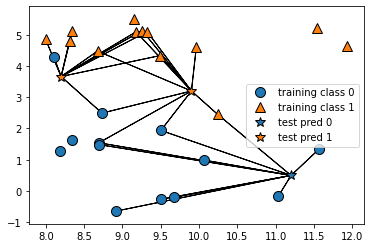

In [32]:
knn = KNeighborsClassifier(n_neighbors=10)
knn=knn.fit(x1_train, y1_train)
pred = knn.predict(x1_val)
pred
print("Training set score: {:.2f}".format(knn.score(x1_train, y1_train)))
print("Validation set score: {:.2f}".format(knn.score(x1_val, y1_val)))

# KNN Plot
mglearn.plots.plot_knn_classification(n_neighbors=10)
plt.show()

In [33]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y1_val,pred))
print(classification_report(y1_val,pred))

[[5970 1296]
 [1801  948]]
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      7266
           1       0.42      0.34      0.38      2749

    accuracy                           0.69     10015
   macro avg       0.60      0.58      0.59     10015
weighted avg       0.67      0.69      0.68     10015



## Test Data using SVM Model

### Import Data from AWS S3 to SageMaker

In [ ]:
# data_key_test = 'H2.csv'
# data_location_test = 's3://{}/{}'.format(bucket, data_key_test)

# h2data = pd.read_csv(data_location_test)

### Import Data From Azure Blob Storage to Azure Machine Learning Studio

In [ ]:
# sas_url = "enter url here"
# blob_client = BlobClient.from_blob_url(sas_url)
# downloaded_blo = blob_client.download_blob()

# from io import StringIO
# blob_data = blob_client.download_blob()
# h2data = pd.read_csv(StringIO(blob_data.content_as_text()))
# print(h2data)

### Import CSV

In [34]:
h2data = pd.read_csv('H2.csv')
a=h2data.head()
a

IsCanceled  LeadTime  ArrivalDateYear ArrivalDateMonth  \
0           0         6             2015             July   
1           1        88             2015             July   
2           1        65             2015             July   
3           1        92             2015             July   
4           1       100             2015             July   

   ArrivalDateWeekNumber  ArrivalDateDayOfMonth  StaysInWeekendNights  \
0                     27                      1                     0   
1                     27                      1                     0   
2                     27                      1                     0   
3                     27                      1                     2   
4                     27                      2                     0   

   StaysInWeekNights  Adults  Children  ...      DepositType        Agent  \
0                  2       1       0.0  ...  No Deposit                 6   
1                  4       2       0.0  ...  No Deposit                 9   
2                  4       1       0.0  ...  No Deposit                 9   
3                  4       2       0.0  ...  No Deposit                 9   
4                  2       2       0.0  ...  No Deposit                 9   

       Company DaysInWaitingList CustomerType   ADR  RequiredCarParkingSpaces  \
0         NULL                 0    Transient   0.0                         0   
1         NULL                 0    Transient  76.5                         0   
2         NULL                 0    Transient  68.0                         0   
3         NULL                 0    Transient  76.5                         0   
4         NULL                 0    Transient  76.5                         0   

   TotalOfSpecialRequests ReservationStatus ReservationStatusDate  
0                       0         Check-Out            2015-07-03  
1                       1          Canceled            2015-07-01  
2                       1          Canceled            2015-04-30  
3                       2          Canceled            2015-06-23  
4                       1          Canceled            2015-04-02  

[5 rows x 31 columns]

In [35]:
type(h2data)

pandas.core.frame.DataFrame

In [36]:
t_leadtime = h2data['LeadTime'] #1
t_arrivaldateyear = h2data['ArrivalDateYear']
t_arrivaldateweekno = h2data['ArrivalDateWeekNumber']
t_arrivaldatedayofmonth = h2data['ArrivalDateDayOfMonth']
t_staysweekendnights = h2data['StaysInWeekendNights'] #2
t_staysweeknights = h2data['StaysInWeekNights'] #3
t_adults = h2data['Adults'] #4
t_children = h2data['Children'] #5
t_babies = h2data['Babies'] #6
t_previouscancellations = h2data['PreviousCancellations'] #12
t_previousbookingsnotcanceled = h2data['PreviousBookingsNotCanceled'] #13
t_bookingchanges = h2data['BookingChanges'] #16
t_dayswaitinglist = h2data['DaysInWaitingList'] #20
t_adr = h2data['ADR'] #22
t_rcps = h2data['RequiredCarParkingSpaces'] #23
t_totalsqr = h2data['TotalOfSpecialRequests'] #24

In [37]:
t_arrivaldatemonth = h2data.ArrivalDateMonth.astype("category").cat.codes
t_arrivaldatemonthcat = pd.Series(t_arrivaldatemonth)
t_mealcat=h2data.Meal.astype("category").cat.codes
t_mealcat=pd.Series(t_mealcat)
t_countrycat=h2data.Country.astype("category").cat.codes
t_countrycat=pd.Series(t_countrycat)
t_marketsegmentcat=h2data.MarketSegment.astype("category").cat.codes
t_marketsegmentcat=pd.Series(t_marketsegmentcat)
t_distributionchannelcat=h2data.DistributionChannel.astype("category").cat.codes
t_distributionchannelcat=pd.Series(t_distributionchannelcat)
t_reservedroomtypecat=h2data.ReservedRoomType.astype("category").cat.codes
t_reservedroomtypecat=pd.Series(t_reservedroomtypecat)
t_assignedroomtypecat=h2data.AssignedRoomType.astype("category").cat.codes
t_assignedroomtypecat=pd.Series(t_assignedroomtypecat)
t_deposittypecat=h2data.DepositType.astype("category").cat.codes
t_deposittypecat=pd.Series(t_deposittypecat)
t_customertypecat=h2data.CustomerType.astype("category").cat.codes
t_customertypecat=pd.Series(t_customertypecat)
t_reservationstatuscat=h2data.ReservationStatus.astype("category").cat.codes
t_reservationstatuscat=pd.Series(t_reservationstatuscat)
t_isrepeatedguestcat = h2data.IsRepeatedGuest.astype("category").cat.codes
t_isrepeatedguestcat=pd.Series(t_isrepeatedguestcat)
t_agentcat = h2data.Agent.astype("category").cat.codes
t_agentcat=pd.Series(t_agentcat)
t_companycat = h2data.Company.astype("category").cat.codes
t_companycat=pd.Series(t_companycat)

In [38]:
a = np.column_stack((t_leadtime,t_countrycat,t_marketsegmentcat,t_deposittypecat,t_customertypecat,t_rcps,t_arrivaldateweekno))
a = sm.add_constant(a, prepend=True)
IsCanceled = h2data['IsCanceled']
b = IsCanceled
b=b.values

In [39]:
prh2 = clf.predict(a)
prh2

array([0, 1, 1, ..., 0, 0, 0])

In [40]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(b,prh2))
print(classification_report(b,prh2))

[[34581 11647]
 [11247 21855]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     46228
           1       0.65      0.66      0.66     33102

    accuracy                           0.71     79330
   macro avg       0.70      0.70      0.70     79330
weighted avg       0.71      0.71      0.71     79330

